Air Quality Index Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('station_day.csv')


In [2]:
data.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [5]:
data.shape

(79569, 16)

In [3]:
data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,61783.000000,52207.000000,65786.000000,66358.000000,66860.000000,44650.000000,68187.000000,57865.000000,59841.000000,53647.000000,47508.000000,13102.000000,63037.000000
mean,87.384388,172.086750,26.947309,37.462226,46.202106,30.149364,1.820432,13.680405,39.154676,3.376202,18.753160,2.571317,196.211114
std,81.666276,130.580527,37.965123,31.124809,48.969508,23.875819,4.944065,14.158937,44.011260,10.866176,32.554796,6.245805,139.494088
min,0.020000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,8.000000
25%,33.850000,75.505000,5.322500,16.180000,15.320000,12.950000,0.590000,5.570000,18.120000,0.230000,0.920000,0.000000,93.000000
50%,60.900000,134.720000,12.460000,29.150000,30.440000,26.165000,0.990000,10.030000,30.560000,1.510000,6.000000,0.450000,151.000000
75%,111.855000,233.805000,30.720000,49.850000,58.352500,40.420000,1.590000,16.880000,47.890000,4.080000,24.040000,2.540000,288.000000
max,1000.000000,1000.000000,470.000000,397.770000,467.630000,418.900000,175.810000,195.650000,963.000000,455.030000,454.850000,170.370000,2049.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79569 entries, 0 to 79568
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StationId   79569 non-null  object 
 1   Date        79569 non-null  object 
 2   PM2.5       61783 non-null  float64
 3   PM10        52207 non-null  float64
 4   NO          65786 non-null  float64
 5   NO2         66358 non-null  float64
 6   NOx         66860 non-null  float64
 7   NH3         44650 non-null  float64
 8   CO          68187 non-null  float64
 9   SO2         57865 non-null  float64
 10  O3          59841 non-null  float64
 11  Benzene     53647 non-null  float64
 12  Toluene     47508 non-null  float64
 13  Xylene      13102 non-null  float64
 14  AQI         63037 non-null  float64
 15  AQI_Bucket  63037 non-null  object 
dtypes: float64(13), object(3)
memory usage: 9.7+ MB


In [7]:
data.isnull().sum()

,0
StationId,0
Date,0
PM2.5,17786
PM10,27362
NO,13783
NO2,13211
NOx,12709
NH3,34919
CO,11382
SO2,21704


In [9]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))


In [10]:
data.sort_values('Date', inplace=True)
data.interpolate(method='linear', inplace=True)


<ipython-input-10-ba387a5dd913>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


In [11]:
data.drop(columns=['Xylene'], inplace=True)

# Data Cleaning

In [14]:
# Data Cleaning
def clean_data(data):
    """Cleans the dataset by handling missing values and invalid data."""
    # Convert 'Date' to datetime format
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

    # Handle missing values in numeric columns by filling with median
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))

    # Drop rows with invalid dates
    data.dropna(subset=['Date'], inplace=True)

    # Reset index after cleaning
    data.reset_index(drop=True, inplace=True)

    return data

data = clean_data(data)

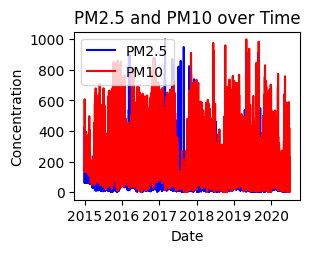

In [15]:
# Time Series Plots for PM2.5, PM10, NO, NO2, O3, CO
plt.subplot(2, 2, 1)
plt.plot(data['Date'], data['PM2.5'], label='PM2.5', color='blue')
plt.plot(data['Date'], data['PM10'], label='PM10', color='red')
plt.title('PM2.5 and PM10 over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()


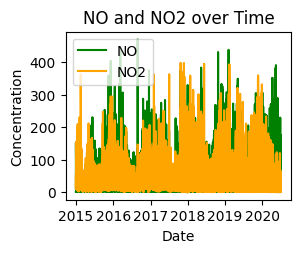

In [16]:
plt.subplot(2, 2, 2)
plt.plot(data['Date'], data['NO'], label='NO', color='green')
plt.plot(data['Date'], data['NO2'], label='NO2', color='orange')
plt.title('NO and NO2 over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

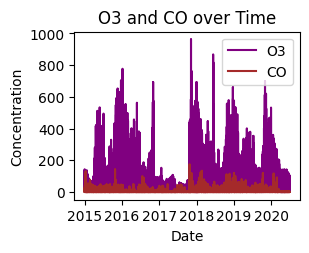

In [17]:
plt.subplot(2, 2, 3)
plt.plot(data['Date'], data['O3'], label='O3', color='purple')
plt.plot(data['Date'], data['CO'], label='CO', color='brown')
plt.title('O3 and CO over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

In [18]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

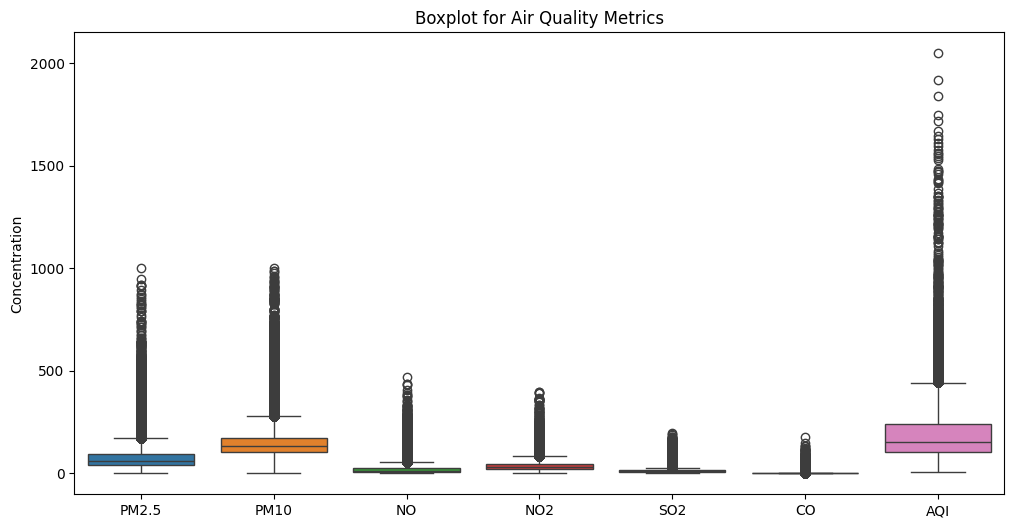

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['PM2.5', 'PM10', 'NO', 'NO2', 'SO2', 'CO', 'AQI']])
plt.title('Boxplot for Air Quality Metrics')
plt.ylabel('Concentration')
plt.show()

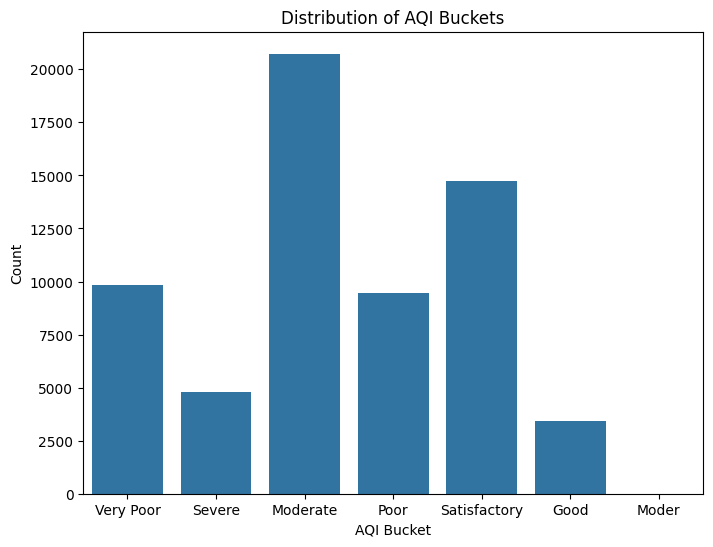

In [20]:
# AQI distribution (if you want to see how AQI is distributed in terms of buckets)
plt.figure(figsize=(8, 6))
sns.countplot(x='AQI_Bucket', data=data)
plt.title('Distribution of AQI Buckets')
plt.xlabel('AQI Bucket')
plt.ylabel('Count')
plt.show()

# Exploratory Data Analysis (EDA)


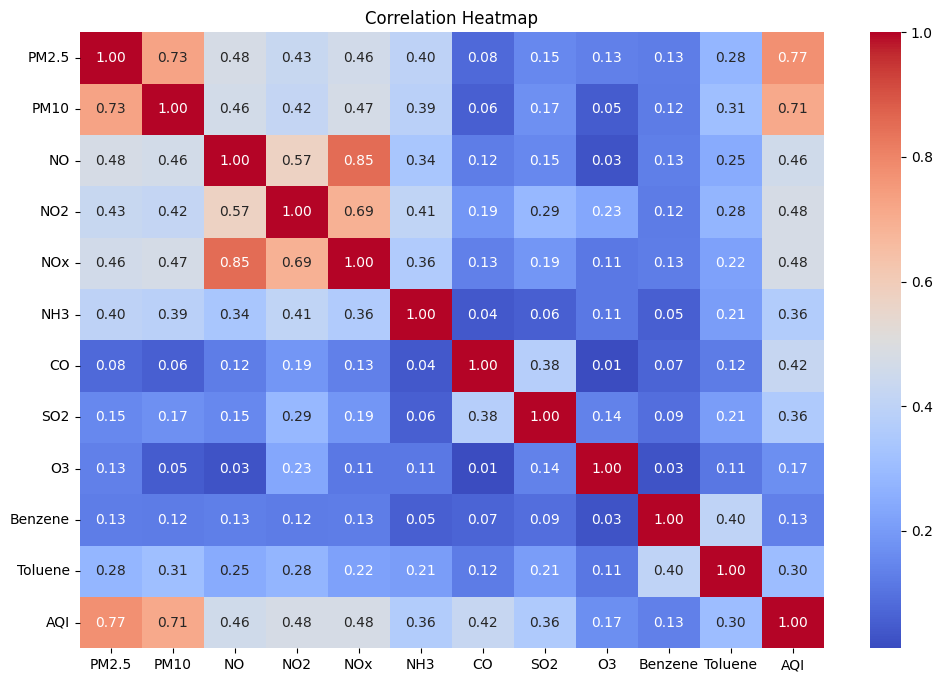

In [21]:
# Fix for correlation heatmap to handle non-numeric columns
def plot_correlation_heatmap(data):
    # Select only numeric columns for correlation
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    corr = numeric_data.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(data)


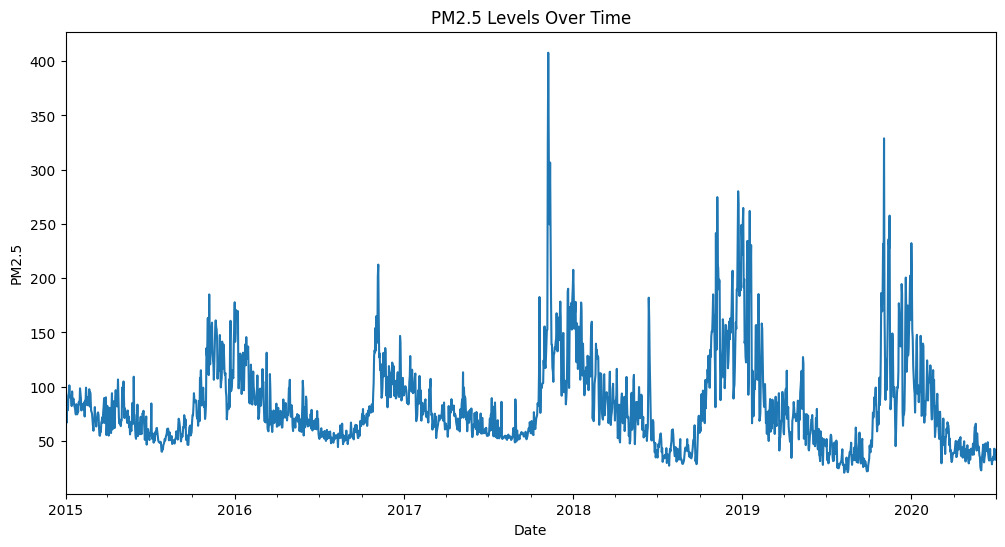

In [22]:

def plot_time_series(data, column, title):
    """Plots a time series for the specified column."""
    plt.figure(figsize=(12, 6))
    data.groupby('Date')[column].mean().plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()

plot_time_series(data, 'PM2.5', 'PM2.5 Levels Over Time')


# Prepare Data for Modeling


In [23]:
# Prepare Data for Modeling
def prepare_data(data):
    """Prepares features and target variables for training and testing."""
    features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    target = 'AQI'

    # Drop rows with missing values in features or target
    data = data.dropna(subset=features + [target])

    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(data)


# Train a Random Forest Model

In [49]:
def train_model(X_train, y_train):
    """Trains a Random Forest Regressor model."""
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model

model = train_model(X_train, y_train)

# Evaluate the Model


In [50]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R-Squared (R2):", r2_score(y_test, y_pred))

evaluate_model(model, X_test, y_test)

Mean Absolute Error (MAE): 20.90158221315058
Mean Squared Error (MSE): 1613.103694683879
Root Mean Squared Error (RMSE): 40.16346218497453
R-Squared (R2): 0.8984326621012426


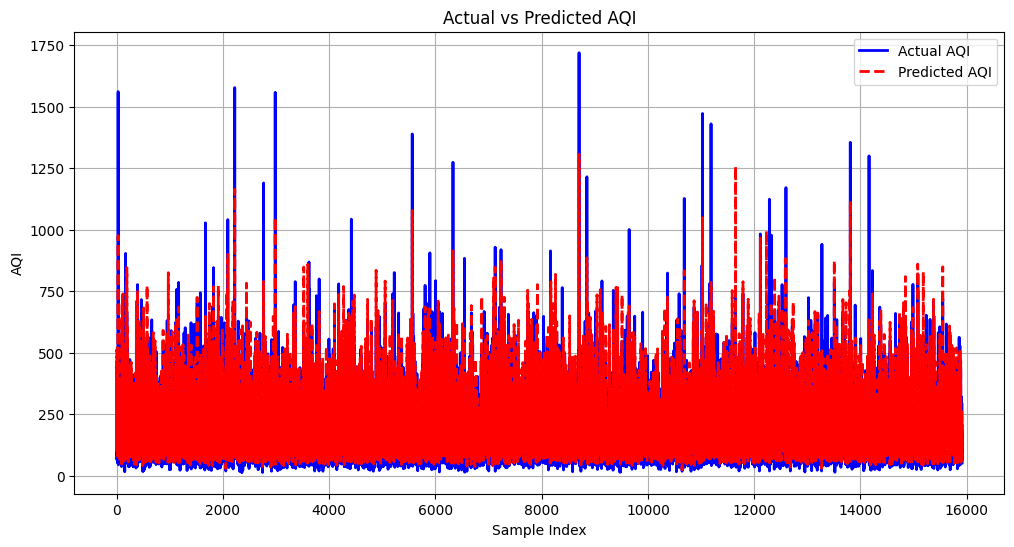

In [51]:
def visualize_actual_vs_predicted(y_test, y_pred):
    """Visualizes actual vs predicted values as separate lines."""
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual AQI', color='blue', linewidth=2)
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted AQI', color='red', linestyle='--', linewidth=2)
    plt.title('Actual vs Predicted AQI')
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize predictions
visualize_actual_vs_predicted(y_test, model_lr.predict(X_test))


# Feature Importance

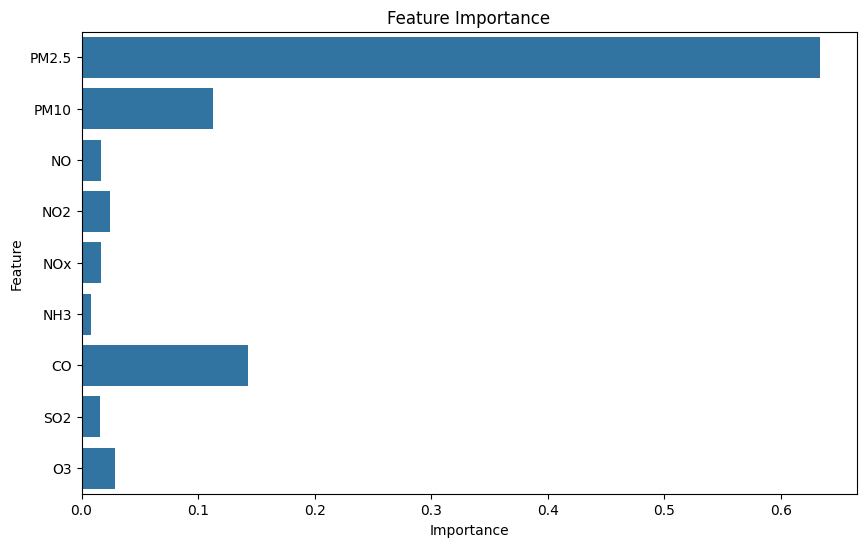

In [26]:
# Feature Importance
def plot_feature_importance(model, feature_names):
    """Plots feature importance for the trained model."""
    importance = model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(model, X_train.columns)

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

def train_gradient_boosting_model(X_train, y_train):
    """Trains a Gradient Boosting Regressor model."""
    model = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    return model

model_gb = train_gradient_boosting_model(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R-Squared (R2):", r2_score(y_test, y_pred))

evaluate_model(model_gb, X_test, y_test)


Mean Absolute Error (MAE): 24.574086335205607
Mean Squared Error (MSE): 1774.1789185237167
Root Mean Squared Error (RMSE): 42.12100329436274
R-Squared (R2): 0.8882907340027736


In [44]:
from sklearn.linear_model import LinearRegression

def train_linear_regression_model(X_train, y_train):
    """Trains a Linear Regression model."""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

model_lr = train_linear_regression_model(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R-Squared (R2):", r2_score(y_test, y_pred))

evaluate_model(model_lr, X_test, y_test)


Mean Absolute Error (MAE): 34.506450462014264
Mean Squared Error (MSE): 3072.6299245511386
Root Mean Squared Error (RMSE): 55.43130816200479
R-Squared (R2): 0.8065351639741443


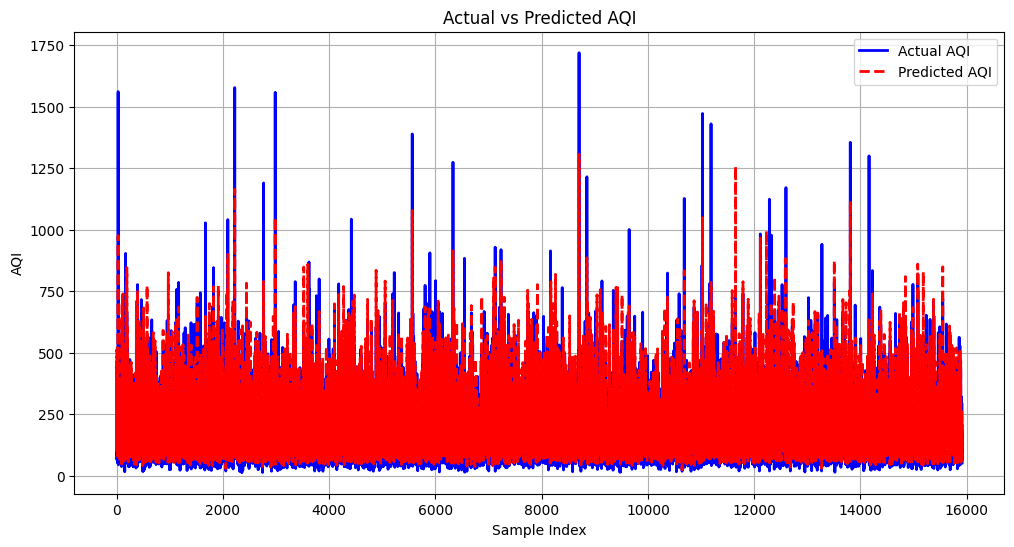

In [53]:
def visualize_actual_vs_predicted(y_test, y_pred):
    """Visualizes actual vs predicted values as separate lines."""
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual AQI', color='blue', linewidth=2)
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted AQI', color='red', linestyle='--', linewidth=2)
    plt.title('Actual vs Predicted AQI')
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize predictions
visualize_actual_vs_predicted(y_test, model_lr.predict(X_test))


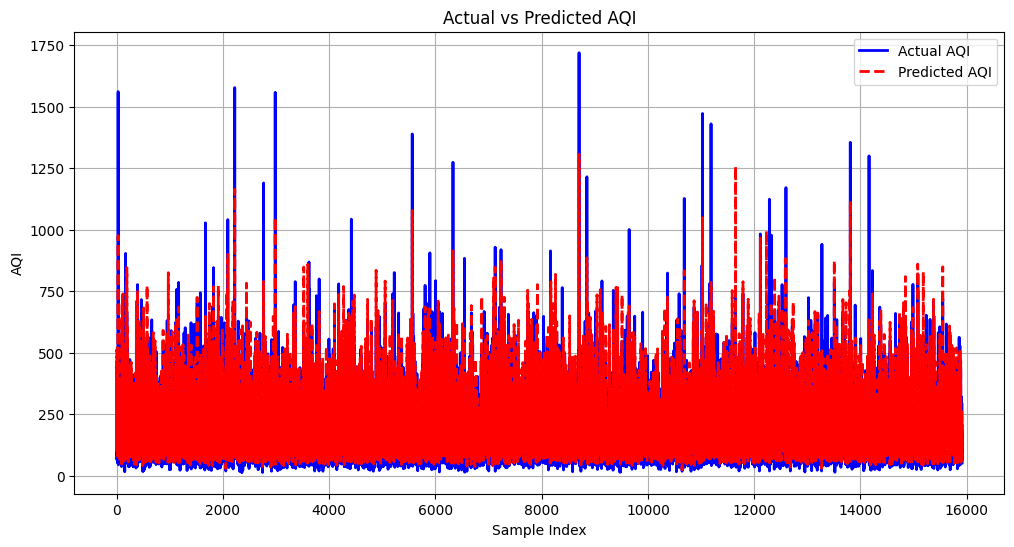

In [48]:
def visualize_actual_vs_predicted(y_test, y_pred):
    """Visualizes actual vs predicted values as separate lines."""
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual AQI', color='blue', linewidth=2)
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted AQI', color='red', linestyle='--', linewidth=2)
    plt.title('Actual vs Predicted AQI')
    plt.xlabel('Sample Index')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize predictions
visualize_actual_vs_predicted(y_test, model_lr.predict(X_test))


# Save the Cleaned Data and Model

In [29]:
def save_outputs(data, model, data_path='cleaned_aqi_data.csv', model_path='aqi_prediction_model.pkl'):
    """Saves the cleaned dataset and trained model."""
    data.to_csv(data_path, index=False)
    joblib.dump(model, model_path)
    print("Cleaned data saved to:", data_path)
    print("Model saved to:", model_path)

save_outputs(data, model)

Cleaned data saved to: cleaned_aqi_data.csv
Model saved to: aqi_prediction_model.pkl


In [28]:
import joblib
print("Pipeline complete: Data cleaning, visualization, modeling, and evaluation.")

Pipeline complete: Data cleaning, visualization, modeling, and evaluation.


In [30]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [31]:
import gradio as gr
import joblib
import pandas as pd

# Load the trained model
model = joblib.load('aqi_prediction_model.pkl')

# Define a function to make predictions using the trained model
def predict_aqi(PM2_5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3):
    """Predict AQI based on the input features using the trained model."""
    # Create a DataFrame with the input features
    input_data = pd.DataFrame([[PM2_5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3]],
                              columns=['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3'])

    # Make the prediction using the model
    predicted_aqi = model.predict(input_data)[0]
    return predicted_aqi

# Define the Gradio interface with the new syntax
inputs = [
    gr.Number(label='PM2.5'),
    gr.Number(label='PM10'),
    gr.Number(label='NO'),
    gr.Number(label='NO2'),
    gr.Number(label='NOx'),
    gr.Number(label='NH3'),
    gr.Number(label='CO'),
    gr.Number(label='SO2'),
    gr.Number(label='O3')
]

outputs = gr.Textbox(label="Predicted AQI")

# Create the interface
gr.Interface(fn=predict_aqi, inputs=inputs, outputs=outputs, title="AQI Prediction",
             description="Enter the values of air pollutants to predict AQI").launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e593d94bc2405399b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
